In [1]:
import skgeom as sg
import os
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiLineString, Point, LineString
from shapely.ops import polygonize
import numpy as np 
import geopandas as gp
from skgeom.draw import draw
import pandas as pd
from tqdm import tqdm
from collections import Counter
from skgeom import Point2, Polygon as sgPolygon, PolygonWithHoles


In [2]:
cd = os.getcwd()
inp = cd + "\\data\\"
out = cd + "\\output\\"

In [139]:
#Files
boyce_clark = "bc.shp"
griffin = "GFF.shp"
su = "SU.shp"
cd_f = "CD.shp"
pp = "Polsby_Popper.shp"
pp_h = "Polsby_Poper_holes.shp"

gdf_boyce_clark = gp.read_file(inp + boyce_clark)
gdf_griffin = gp.read_file(inp + griffin)
gdf_su = gp.read_file(inp + su)
gdf_cdf = gp.read_file(inp + cd_f)
gdf_pp = gp.read_file(inp + pp)
gdf_pp_h = gp.read_file(inp + pp_h)

In [275]:
###################################
######### Functions :) ############
###################################


def convert_pol(polygon_shapely):
    """Converts a shapely polygon into a scikit-geometry polygon
    Accounts for polygons with and without holes."""
    #extract the exterior coordinates
    exterior_coords = [Point2(x, y) for x, y in polygon_shapely.exterior.coords[:-1]] 
    exterior_coords = exterior_coords[::-1]
    #check if the polygon has holes and convert to sg geometries
    if len(polygon_shapely.interiors) > 0:
        holes = []
        for interior in polygon_shapely.interiors:
            interior_coords = [Point2(x, y) for x, y in interior.coords[:-1]]
            interior_coords = interior_coords[::-1]
            holes.append(sgPolygon(interior_coords))  # Append the hole as a list of Point2 objects
        return PolygonWithHoles(sgPolygon(exterior_coords), holes)
    else:
        # Create a simple Polygon if there are no holes
        return sgPolygon(exterior_coords)




def convert_skel(skel):

    
    line_strings = []
    seen_edges = set()
    
    for edge in skel.halfedges:
        if edge.is_bisector:
            start_point_x = float(edge.vertex.point.x())
            start_point_y = float(edge.vertex.point.y())
            end_point_x = float(edge.opposite.vertex.point.x())
            end_point_y = float(edge.opposite.vertex.point.y())
            
            # Create sorted tuple to represent the edge in a direction-agnostic way
            sorted_edge = tuple(sorted(((start_point_x, start_point_y), (end_point_x, end_point_y))))
            
            if sorted_edge not in seen_edges:
                seen_edges.add(sorted_edge)
                line = LineString([sorted_edge[0], sorted_edge[1]])
                line_strings.append(line)
    
    multi_line = MultiLineString(line_strings)
    lengths = [line.length for line in line_strings]
    max_length = max(lengths, default=0)
    min_length = min(lengths, default=0)
    std_length = np.std(lengths) if lengths else 0
    
    confluence_points_count, _ = count_confluence_points(line_strings)

    return multi_line, max_length, std_length, confluence_points_count, min_length

def convert_lines_to_shapely(line_strings):
    """Converts list of line endpoints to Shapely MultiLineString and calculates lengths."""
    shapely_lines = [LineString(line) for line in line_strings]
    lengths = [line.length for line in shapely_lines]
    return MultiLineString(shapely_lines), lengths

def count_confluence_points(line_strings,  precision=4):
    """Counts endpoints appearing in multiple lines, identifying confluence points."""
    # endpoints = [Point(coord) for line in line_strings for coord in line.coords]
    # endpoint_counts = Counter(endpoints)
    # confluence_points = {pt: count for pt, count in endpoint_counts.items() if count > 1}
    def round_point(point, prec):
        return Point(round(point.x, prec), round(point.y, prec))
    
    endpoints = [round_point(Point(coord), precision) for line in line_strings for coord in line.coords]
    endpoint_counts = Counter(endpoints)
    
    # Filter for points that occur more than once, indicating confluence
    confluence_points = {pt: count for pt, count in endpoint_counts.items() if count > 1}
    
    return len(confluence_points), confluence_points

def skel_compactness(gdf, id_col):
    #Create dict to store all skeletons
    skel_dict = {}
    # gdf['skel_length'] = 0.0 #initialize length
    # gdf['isoperim_q'] = 0.0
    # gdf['skel_comp'] = 0.0
    inter = []
    std = []
    maxlength = []
    minlength = []
    ispe_q = []
    skel_length = []

    
    pbar = tqdm(total = len(gdf), position = 0, leave=True)
    for i, row in gdf.iterrows():
        #Get ID
        id_pol = row[id_col]
        pol = gdf.loc[i, 'geometry']
        #Check if geometry is a circle
        T = 4*np.pi*(pol.area / (pol.length)**2) #calculate the isoperimetric quotient to check if the geometry is a circumference
        if T>=0.99:
            skel_dict[id_pol] = pol.centroid
            std.append(0.0)
            ispe_q.append(T)
            inter.append(0.0)
            maxlength.append(0.0)
            minlength.append(0)
            skel_length.append(0)
        else:
            #convert to scikit-geometry polygon
            sg_pol = convert_pol(pol)
            #Create a skeleton
            skel = sg.skeleton.create_interior_straight_skeleton(sg_pol)
            #Convert skeleton to shapely geometry
            sp_skel, maxL, stdL, insec, minL = convert_skel(skel)
            #Calculate length
            std.append(stdL)
            maxlength.append(maxL)
            minlength.append(minL)
            inter.append(insec)
            ispe_q.append(T)
            skel_length.append(sp_skel.length)
            #Add skeleton to dict
            skel_dict[id_pol] = sp_skel
        pbar.update(1)
    pbar.close()
    
    #create a geodataframe with the skeletons
    data = list(skel_dict.items())
    df_skel = pd.DataFrame(data, columns=['id', 'geometry'])
    gdf_skel = gp.GeoDataFrame(df_skel, crs = gdf.crs, geometry='geometry')

    #create attributes
    gdf['stdL'] = std
    gdf['maxL'] = maxlength
    gdf['minL'] = minlength
    gdf['n_inter'] = inter
    gdf['skel_length'] = skel_length

    #Calculate the compactness measures
    gdf['skel_density'] = gdf.skel_length/gdf.area
    gdf['skel_perimeter'] = gdf.skel_length/gdf.length
    gdf['isoper_q'] = ispe_q
    gdf['skel_comp'] = gdf['isoper_q']*(1-((gdf['stdL']*gdf['n_inter'])/gdf['skel_length']))
    gdf['skel_comp'] = np.where(gdf['isoper_q']>0.99, 1, gdf['skel_comp'] )

    #gdf['normalized_intersections'] = np.log1p(gdf['n_inter']) / np.log1p(gdf['n_inter'].max())
    #gdf['weighted_compactness'] = (1 - gdf['stdL'] / gdf['maxL']) * np.exp(-gdf['normalized_intersections']) * gdf['isoper_q']
    #gdf['weighted_compactness'] = (1 - gdf['stdL'] / gdf['maxL']) * gdf['normalized_intersections'] * gdf['isoper_q']
    #gdf['weighted_compactness'] =  np.where(gdf['isoper_q']>0.99, 1, gdf['weighted_compactness'] )
    gdf['comp_noint'] = (1-(gdf['stdL']/(0.00000001+gdf['maxL']-gdf['minL'])))* gdf['isoper_q']
    gdf['comp_noint'] =  np.where(gdf['isoper_q']>0.99, 1, gdf['comp_noint'] )
    return gdf, gdf_skel

def plot_skel(gdf_polygon, gdf_skeleton, id_Col, comp_meas):
    _, ax = plt.subplots(figsize=(10, 10)) 

    gdf_polygon.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5, label='Polygon')
    gdf_skeleton.plot(ax=ax, color='red', linewidth=0.7, label='Skeleton')

    #annotate each polygon with its ID and compactness measure, positioned below the polygon :) 
    for index, row in gdf_polygon.iterrows():
        bbox = row['geometry'].bounds
        centroid = row['geometry'].centroid
        x_position = centroid.x
        y_position = bbox[1] - 0.01  
        text = f"ID: {row[id_Col]}\nComp.: {row[comp_meas]:.2f}" 
        ax.text(x_position, y_position, text, fontsize=9, ha='center', va='top')
        ax.axis('off')
    plt.legend()

    plt.show()

def plot_polygons(gdf_polygon, id_Col, comp_meas):
    _, ax = plt.subplots(figsize=(10, 10)) 

    gdf_polygon.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5, label='Polygon')

    #Annotate each polygon with its IDs :) 
    for _, row in gdf_polygon.iterrows():
        bbox = row['geometry'].bounds  
        centroid = row['geometry'].centroid
        x_position = centroid.x
        y_position = bbox[1] - 0.01  

        text = f"ID: {row[id_Col]}\nComp.: {row[comp_meas]:.2f}" 
        ax.text(x_position, y_position, text, fontsize=9, ha='center', va='top')
    ax.set_title('Polygons')
    ax.axis('off')
    plt.legend()  

    plt.show()

## Polsby Popper

In [276]:
gdf_pp['DISTRICT'] = range(len(gdf_pp))

100%|██████████| 9/9 [00:00<00:00, 13.41it/s]
C:\Users\vanessa610\AppData\Local\Temp\ipykernel_16332\162910667.py:192: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()  # Show legend


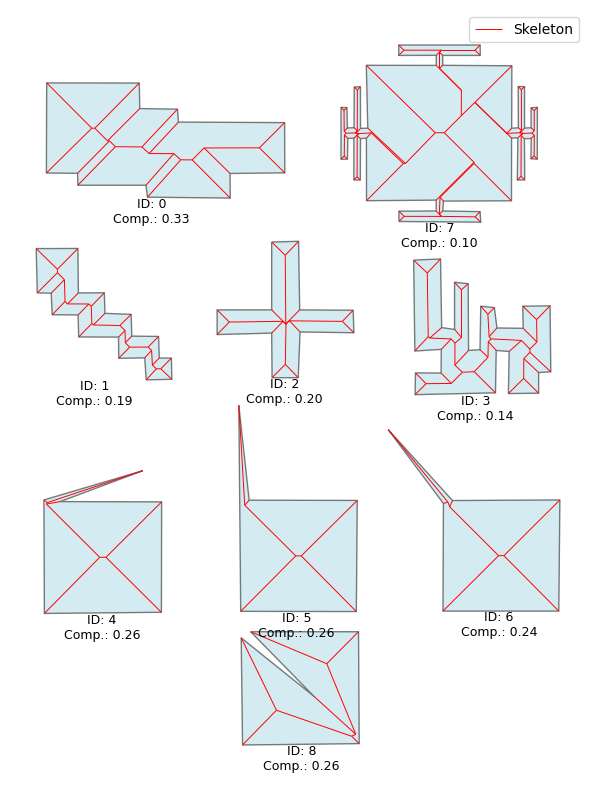

In [277]:
pp_comp, pp_skel = skel_compactness(gdf_pp, "DISTRICT")
plot_skel(pp_comp,pp_skel, "DISTRICT", "comp_noint")

C:\Users\vanessa610\AppData\Local\Temp\ipykernel_16332\1841979300.py:218: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()  # Show legend
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


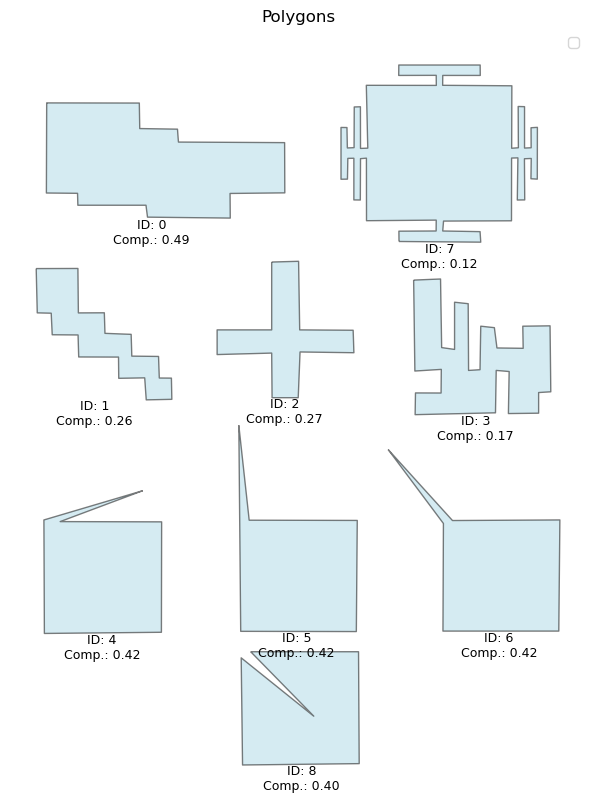

In [228]:
plot_polygons(pp_comp, "DISTRICT", "isoper_q")

In [148]:
gdf_pp_h['DISTRICT'] = range(len(gdf_pp_h))

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 10.21it/s]
C:\Users\vanessa610\AppData\Local\Temp\ipykernel_16332\162910667.py:192: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()  # Show legend


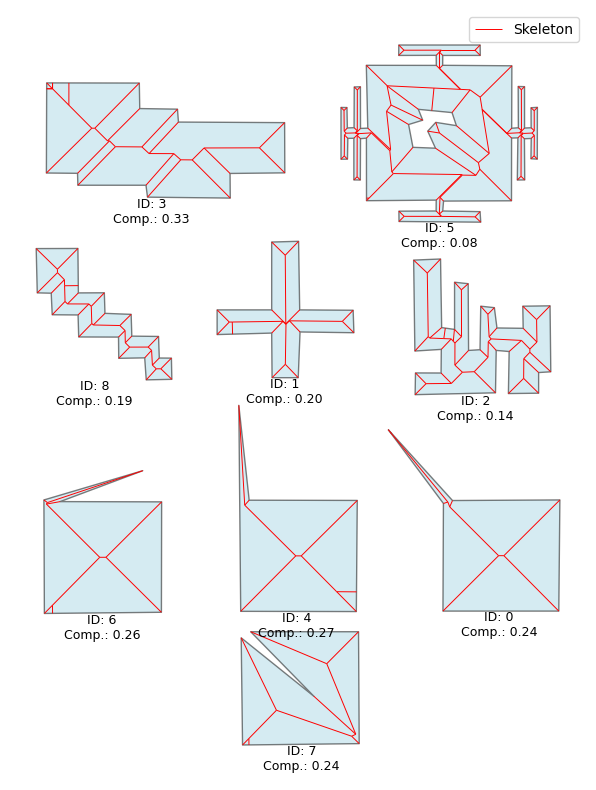

In [278]:
#With holes
pp_h_comp, pp_h_skel = skel_compactness(gdf_pp_h, "DISTRICT")
plot_skel(pp_h_comp,pp_h_skel, "DISTRICT", "comp_noint")

C:\Users\vanessa610\AppData\Local\Temp\ipykernel_16332\1677714656.py:217: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()  # Show legend
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


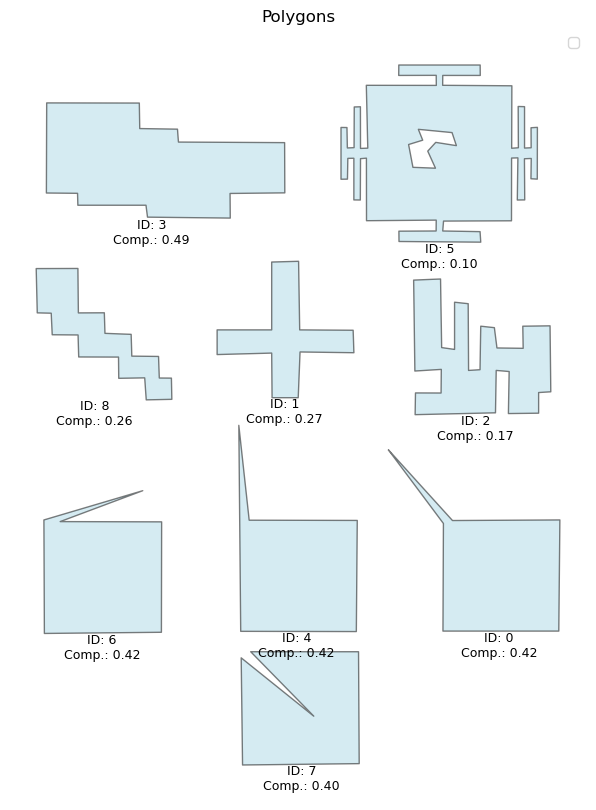

In [154]:
plot_polygons(pp_h_comp, "DISTRICT", "isoper_q")

100%|██████████| 12/12 [00:00<00:00, 54.98it/s]
C:\Users\vanessa610\AppData\Local\Temp\ipykernel_16332\162910667.py:192: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()  # Show legend


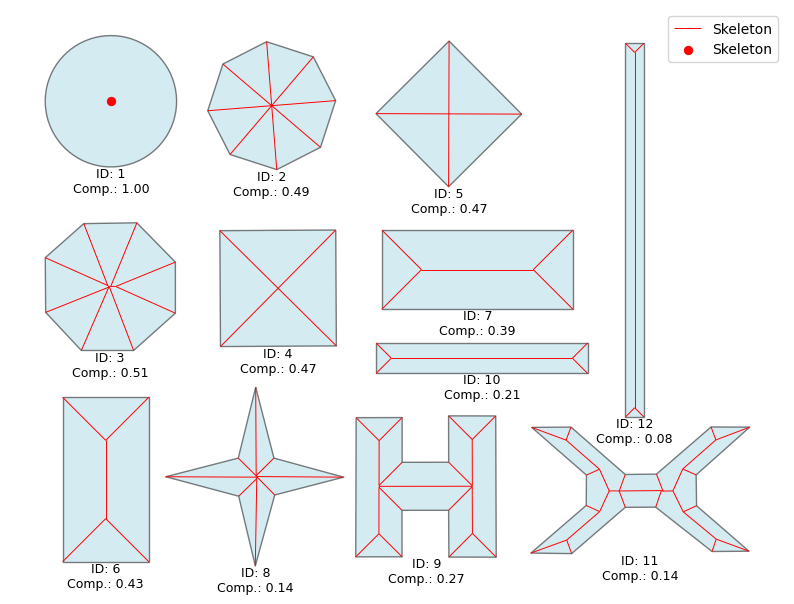

In [279]:
su_comp, skel_su = skel_compactness(gdf_su, "DISTRICT")
plot_skel(su_comp,skel_su, "DISTRICT", "comp_noint")

100%|██████████| 12/12 [00:00<00:00, 57.45it/s]
C:\Users\vanessa610\AppData\Local\Temp\ipykernel_16332\162910667.py:192: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()  # Show legend


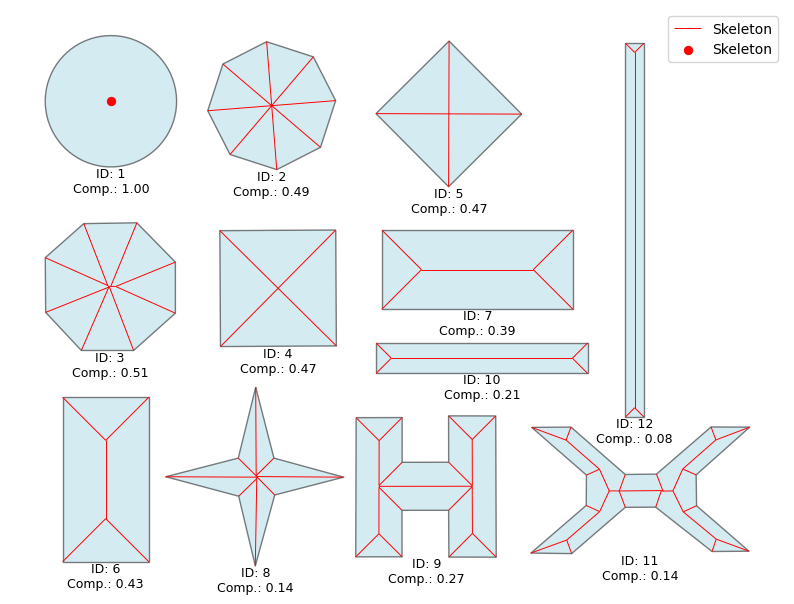

In [280]:
su_comp, skel_su = skel_compactness(gdf_su, "DISTRICT")
plot_skel(su_comp,skel_su, "DISTRICT", "comp_noint")

C:\Users\vanessa610\AppData\Local\Temp\ipykernel_16332\1841979300.py:218: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()  # Show legend
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


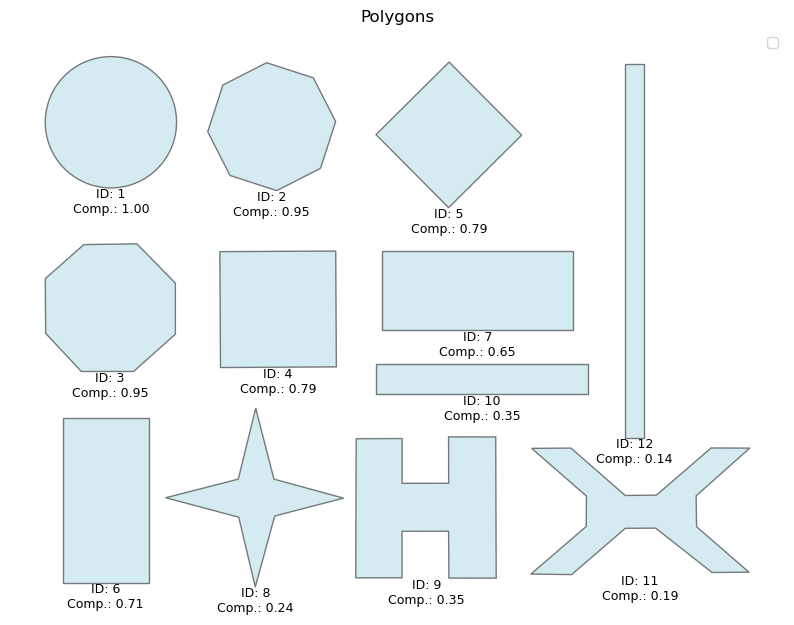

In [232]:
plot_polygons(su_comp, "DISTRICT", "isoper_q")

## Boyce and Clarck polygons

In [188]:
## Code from zhongqi - Week 2

def boyce_clark_index(distance):
    """
    INPUT
    ---------------------
    distance : NumPy array of radial line length

    OUTPUT
    ---------------------
    Boyce-Clark Index
    """
    return sum(abs((distance / sum(distance))*100 - (100/len(distance))))

def radial_line_distance(shape, num, r):
    """
    INPUT
    ---------------------
    shape : geometry of polygon
    num : number of radial lines
    r : initial length (or radius of minimum enclosing circle for the shape)
    
    OUTPUT
    ---------------------
    distance : NumPy array of radial line length
    r_line : list of radial line (LineString)
    """
    
    centroid = shape.centroid # generate centroid point as the central node
    distance = []
    r_line = []
    angles = np.linspace(0, 2 * np.pi, num+1) # calculate the angle in radians

    for angle in angles[:-1]:
        # Define a relatively far point on the radial line
        point_on_line = Point(centroid.x + 2 * r * np.cos(angle), centroid.y + 2 * r * np.sin(angle))

        # Create a line from the centroid to the point => radial line
        # Intersect with the polygon => cut off at the boundary
        radial_line = LineString([centroid, point_on_line]).intersection(shape)
        
        try:
            # if MultiLineString, choose the line segment starting from centroid
            for line in radial_line.geoms:
                if centroid.coords[0] == line.coords[0]:
                    radial_line = line
                else:
                    pass
        except:
            pass

        # Calculate and store the distance
        ri = radial_line.length
        distance.append(ri)
        r_line.append(radial_line)
    
    return r_line, np.array(distance)

100%|██████████| 2/2 [00:43<00:00, 21.62s/it]
C:\Users\vanessa610\AppData\Local\Temp\ipykernel_16332\162910667.py:192: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()  # Show legend


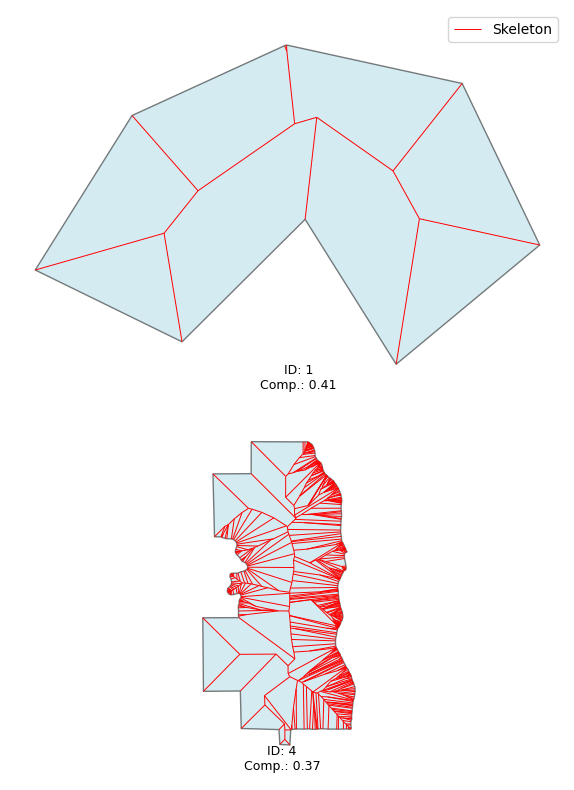

In [281]:
#For the Boyce and Clarc polygons
bc_comp, skel_bc = skel_compactness(gdf_boyce_clark, "DISTRICT")
plot_skel(bc_comp,skel_bc, "DISTRICT", 'comp_noint')

In [235]:
#calculate BC
max_r = bc_comp.minimum_bounding_radius()
n = 32
bc_meas = []

for row, geo in bc_comp.iterrows():
    #Calculate r_i and index
    lines, dd = radial_line_distance(geo.geometry, n, max_r[row])
    index = boyce_clark_index(np.array(dd))
    bc_meas.append(index)

bc_comp['boyce_clarck'] = bc_meas


C:\Users\vanessa610\AppData\Local\Temp\ipykernel_16332\729198491.py:218: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()  # Show legend
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


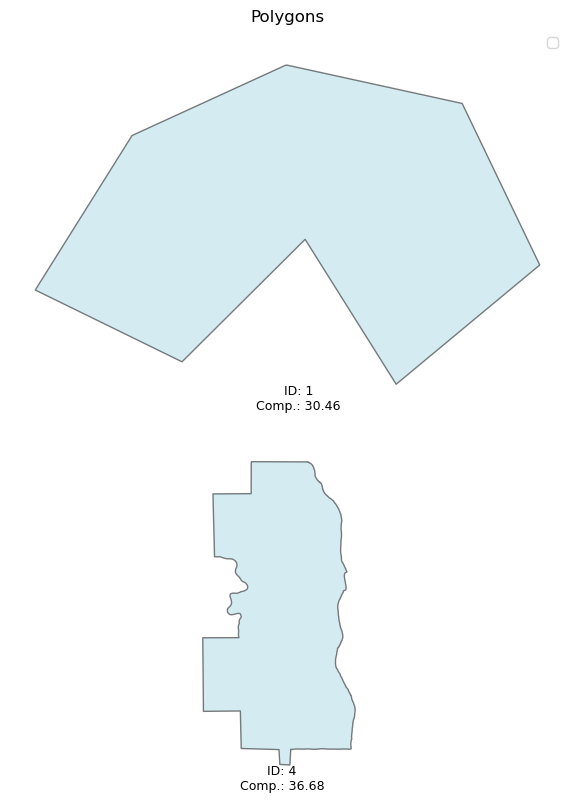

In [224]:
plot_polygons(bc_comp, "DISTRICT", "boyce_clarck")

In [194]:
#calculate BC
max_r = su_comp.minimum_bounding_radius()
n = 32
bc_meas = []

for row, geo in su_comp.iterrows():
    # Calculate r_i and index
    lines, dd = radial_line_distance(geo.geometry, n, max_r[row])
    index = boyce_clark_index(np.array(dd))
    bc_meas.append(index)

su_comp['boyce_clarck'] = bc_meas

C:\Users\vanessa610\AppData\Local\Temp\ipykernel_16332\2748248382.py:218: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()  # Show legend
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


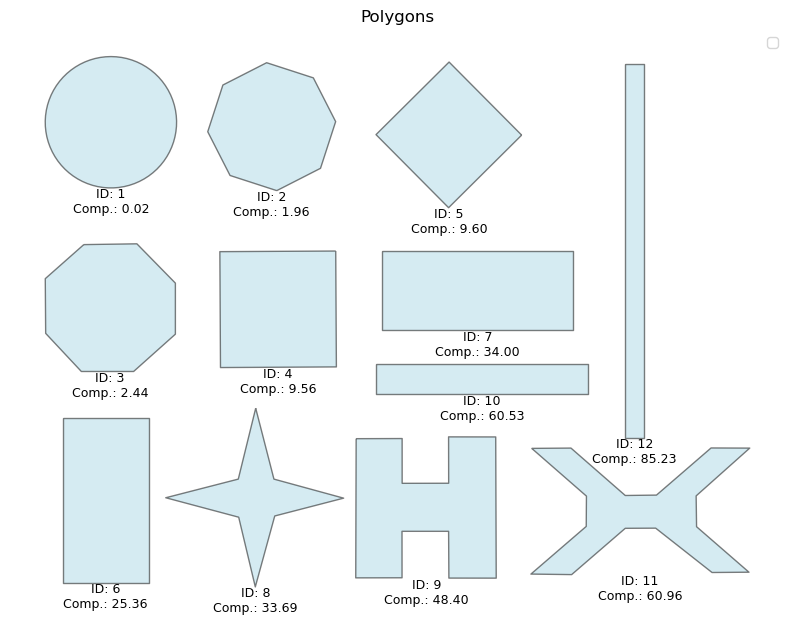

In [195]:
plot_polygons(su_comp, "DISTRICT", "boyce_clarck")

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:36<00:00, 18.35s/it]
C:\Users\vanessa610\AppData\Local\Temp\ipykernel_16332\162910667.py:192: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()  # Show legend


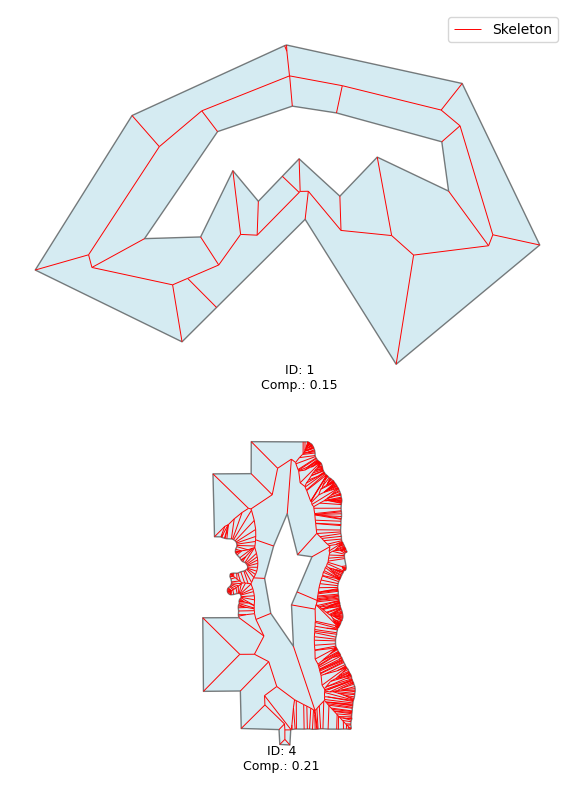

In [282]:
#let's do BC with some holes
gdf_bc_h = gp.read_file(inp+'BC_holes.shp')

bc_comp_h, skel_bc_h = skel_compactness(gdf_bc_h, "DISTRICT")
plot_skel(bc_comp_h,skel_bc_h, "DISTRICT", 'comp_noint')

C:\Users\vanessa610\AppData\Local\Temp\ipykernel_16332\2748248382.py:218: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()  # Show legend
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


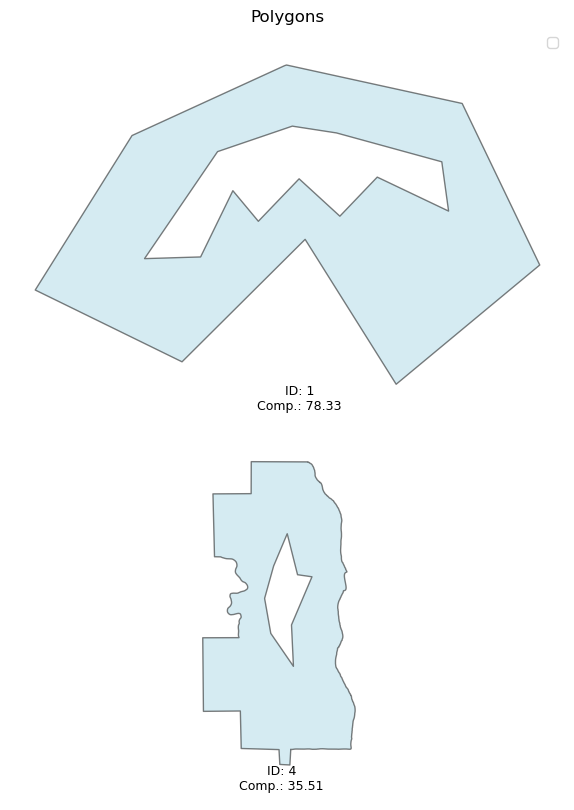

In [202]:
plot_polygons(bc_comp_h, "DISTRICT", "boyce_clarck")

C:\Users\vanessa610\AppData\Local\Temp\ipykernel_16332\1841979300.py:218: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()  # Show legend
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


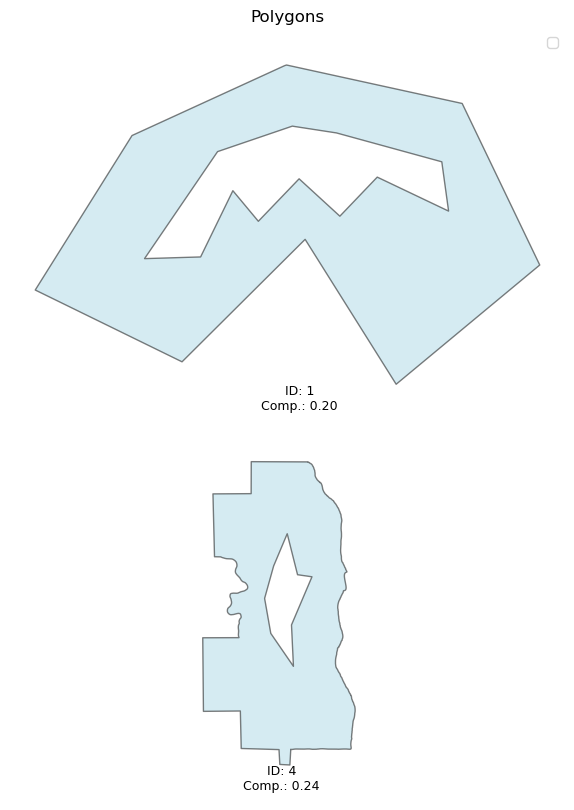

In [237]:
plot_polygons(bc_comp_h, "DISTRICT", "isoper_q")

In [200]:
#calculate BC
max_r = gdf_bc_h.minimum_bounding_radius()
n = 32
bc_meas = []

for row, geo in gdf_bc_h.iterrows():
    # Calculate r_i and index
    lines, dd = radial_line_distance(geo.geometry, n, max_r[row])
    index = boyce_clark_index(np.array(dd))
    bc_meas.append(index)

gdf_bc_h['boyce_clarck'] = bc_meas

## Griffin data

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.39it/s]
C:\Users\vanessa610\AppData\Local\Temp\ipykernel_16332\162910667.py:192: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()  # Show legend


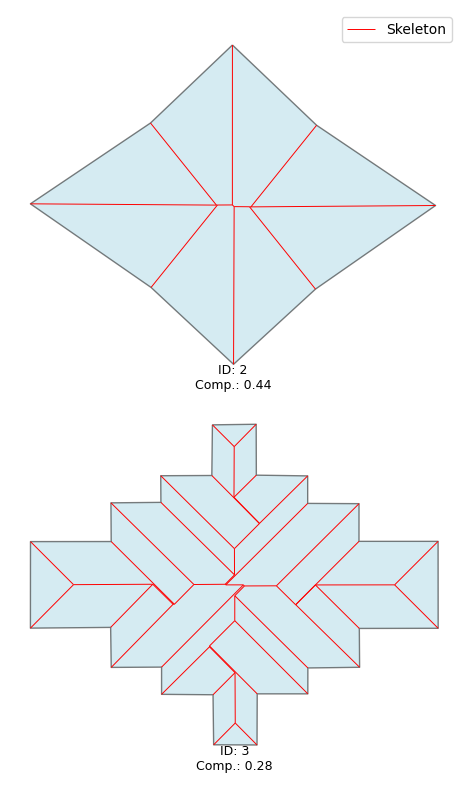

In [283]:
gff_comp, skel_gff = skel_compactness(gdf_griffin, "DISTRICT")
plot_skel(gff_comp,skel_gff, 'DISTRICT', 'comp_noint')

## Su polygons

## Congressional districts

In [60]:
cd_comp, skel_cd = skel_compactness(gdf_cdf, "DISTRICT")
plot_skel(cd_comp,skel_cd, "DISTRICT", "skel_perimeter")

#It takes forever

## Tiger data

In [284]:
#Read tiger data
tiger_shapes = gp.read_file(inp + 'tiger_shapefile.shp')
tiger_shapes['id'] = range(0,len(tiger_shapes))

In [285]:
tiger_com, skel_tiger = skel_compactness(tiger_shapes, "id")

100%|██████████| 51/51 [00:01<00:00, 41.06it/s]


In [286]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import geopandas as gpd
import math

def plot_skel_mosaic(gdf_polygon, gdf_skeleton, id_col, comp_meas, label_col):
    #Calculate the number of rows needed for the subplot
    num_plots = len(gdf_polygon)
    cols = 4
    rows = math.ceil(num_plots / cols)
    
    #Create a large figure to hold the subplots
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=True)
    axs = axs.flatten()  # Flatten the axis array for easier access
    
    for idx, ax in enumerate(axs):
        if idx >= num_plots:
            ax.set_visible(False)  # Hide empty subplots
            continue
        
        poly_row = gdf_polygon.iloc[idx]
        skel_row = gdf_skeleton.iloc[idx]
        
        #Plot the polygon
        gdf_polygon.iloc[[idx]].plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.5)
        
        #Plot the skeleton
        if skel_row['geometry'] is not None:
            if skel_row['geometry'].geom_type == 'MultiLineString':
                for line in skel_row['geometry'].geoms:
                    x, y = line.xy
                    ax.plot(x, y, color='red', linewidth=1.5)
            elif skel_row['geometry'].geom_type == 'LineString': 
                x, y = skel_row['geometry'].xy
                ax.plot(x, y, color='red', linewidth=1.5)

        bbox = poly_row['geometry'].bounds
        x_position = (bbox[0] + bbox[2]) / 2  # Center X position of the bounding box
        y_position = bbox[1]  # Minimum Y position of the bounding box (bottom)
        annotation_text = f"ID: {poly_row[id_col]}\nComp.: {poly_row[comp_meas]:.2f}\n{poly_row[label_col]}"
        ax.text(x_position, y_position, annotation_text, ha='center', va='top', fontsize=14, transform=ax.transData)
        
        ax.axis('off')

    #add a global legend
    legend_elements = [Line2D([0], [0], color='lightblue', lw=4, alpha=0.5, label='Polygon'),
                       Line2D([0], [0], color='red', lw=2, label='Skeleton')]
    fig.legend(handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.05), fontsize=12)

    plt.show()





In [207]:
len(tiger_com)

51

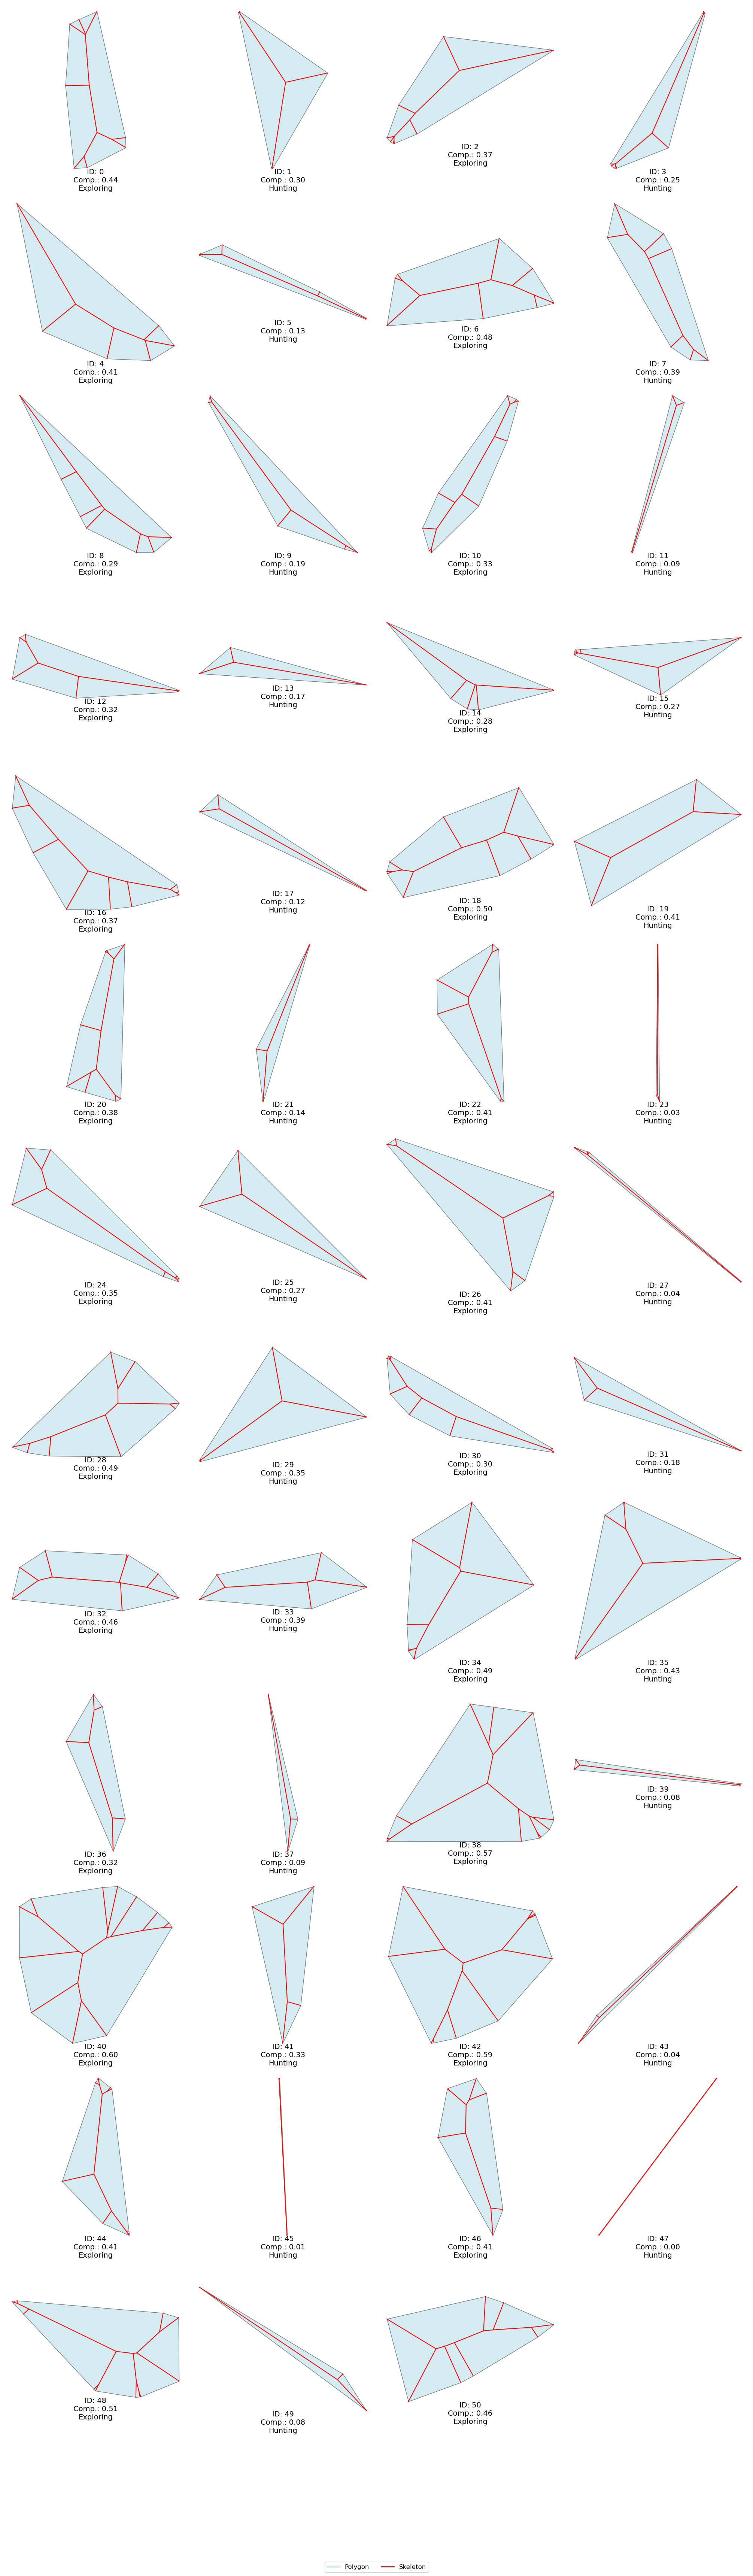

In [287]:
plot_skel_mosaic(tiger_com, skel_tiger, "id", "comp_noint", "label")

## Regression Analysis - Logistic reggresion

In [364]:
tiger_com[['label','comp_noint', 'reock', 'isoper_q', 'boyce_clarck',
        ]].groupby('label').median()

,comp_noint,reock,isoper_q,boyce_clarck
label,,,,
Exploring,0.411933,0.322309,0.574168,28.796771
Hunting,0.168600,0.108547,0.244583,56.942762


In [354]:
tiger_com.keys()

Index(['segment', 'label', 'geometry', 'id', 'stdL', 'maxL', 'minL', 'n_inter',
       'skel_length', 'skel_density', 'skel_perimeter', 'isoper_q',
       'skel_comp', 'comp_noint', 'behavior', 'intercept', 'boyce_clarck',
       'reock', 'moment_of_inertia'],
      dtype='object')

In [341]:
import statsmodels.api as sm
import pandas as pd

# Convert 'behavior' to a binary variable where 1 represents 'hunting' and 0 represents 'exploring'
tiger_com['behavior'] = tiger_com['label'].map({'Hunting': 1, 'Exploring': 0})

# Adding a constant to the model for the intercept
tiger_com['intercept'] = 1

# Define the model
logit_model_sk = sm.Logit(tiger_com['behavior'], tiger_com[['intercept', 'comp_noint']])

# Fit the model
result = logit_model_sk.fit()

# Print the summary results
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.361885
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               behavior   No. Observations:                   51
Model:                          Logit   Df Residuals:                       49
Method:                           MLE   Df Model:                            1
Date:                Thu, 21 Mar 2024   Pseudo R-squ.:                  0.4778
Time:                        21:45:52   Log-Likelihood:                -18.456
converged:                       True   LL-Null:                       -35.341
Covariance Type:            nonrobust   LLR p-value:                 6.206e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5318      1.729      3.199      0.001       2.143       8.921
comp_noint   -17.2190      4.

In [351]:
from sklearn.model_selection import train_test_split

X = tiger_com[['comp_noint']]  #Independent variable
y = tiger_com['behavior']

#Splitting the data (85% train, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


In [352]:

logit_model_train = sm.Logit(y_train, X_train).fit()

print(logit_model_train.summary())

Optimization terminated successfully.
         Current function value: 0.389527
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               behavior   No. Observations:                   43
Model:                          Logit   Df Residuals:                       41
Method:                           MLE   Df Model:                            1
Date:                Thu, 21 Mar 2024   Pseudo R-squ.:                  0.4378
Time:                        22:26:56   Log-Likelihood:                -16.750
converged:                       True   LL-Null:                       -29.794
Covariance Type:            nonrobust   LLR p-value:                 3.262e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3901      1.824      2.956      0.003       1.816       8.964
comp_noint   -16.2347      5.

In [353]:
#Making predictions (the probabilities of being 'hunting')
predictions = logit_model_train.predict(X_test)

#Convert probabilities to binary predictions
predicted_classes = (predictions > 0.5).astype(int)

#Evaluate the model 
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.875


## Evaluate other measures of compactness

In [323]:
#Isoperimetric Quotient
logit_model_iq = sm.Logit(tiger_com['behavior'], tiger_com[['intercept', 'isoper_q']])
result_iq = logit_model_iq.fit()

print(result_iq.summary())


Optimization terminated successfully.
         Current function value: 0.407802
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               behavior   No. Observations:                   51
Model:                          Logit   Df Residuals:                       49
Method:                           MLE   Df Model:                            1
Date:                Thu, 21 Mar 2024   Pseudo R-squ.:                  0.4115
Time:                        21:38:09   Log-Likelihood:                -20.798
converged:                       True   LL-Null:                       -35.341
Covariance Type:            nonrobust   LLR p-value:                 6.925e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.6464      1.452      3.199      0.001       1.800       7.493
isoper_q     -10.2475      2.

In [303]:

X = tiger_com[['isoper_q']] 
y = tiger_com['behavior']

#Splitting the data (85% train, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

logit_model_iq = sm.Logit(y_train, X_train).fit()

print(logit_model_iq.summary())

Optimization terminated successfully.
         Current function value: 0.430564
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               behavior   No. Observations:                   43
Model:                          Logit   Df Residuals:                       41
Method:                           MLE   Df Model:                            1
Date:                Thu, 21 Mar 2024   Pseudo R-squ.:                  0.3786
Time:                        21:26:53   Log-Likelihood:                -18.514
converged:                       True   LL-Null:                       -29.794
Covariance Type:            nonrobust   LLR p-value:                 2.038e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6425      1.596      2.909      0.004       1.515       7.770
isoper_q      -9.8007      3.

In [304]:
predictions = logit_model_iq.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.75


## Boyce Clarck

In [343]:
max_r = tiger_com.minimum_bounding_radius()
n = 32
bc_meas = []

for row, geo in tiger_com.iterrows():
    # Calculate r_i and index
    lines, dd = radial_line_distance(geo.geometry, n, max_r[row])
    index = boyce_clark_index(np.array(dd))
    bc_meas.append(index)

tiger_com['boyce_clarck'] = bc_meas

In [344]:
logit_model_bc = sm.Logit(tiger_com['behavior'], tiger_com[['intercept', 'boyce_clarck']])
result_bc = logit_model_bc.fit()

print(result_bc.summary())

Optimization terminated successfully.
         Current function value: 0.456747
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               behavior   No. Observations:                   51
Model:                          Logit   Df Residuals:                       49
Method:                           MLE   Df Model:                            1
Date:                Thu, 21 Mar 2024   Pseudo R-squ.:                  0.3409
Time:                        21:46:37   Log-Likelihood:                -23.294
converged:                       True   LL-Null:                       -35.341
Covariance Type:            nonrobust   LLR p-value:                 9.178e-07
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -3.8569      1.145     -3.369      0.001      -6.100      -1.613
boyce_clarck     0.0944

In [307]:
X = tiger_com[['boyce_clarck']]  
y = tiger_com['behavior']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

logit_model_train = sm.Logit(y_train, X_train).fit()

print(logit_model_train.summary())

Optimization terminated successfully.
         Current function value: 0.476107
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               behavior   No. Observations:                   43
Model:                          Logit   Df Residuals:                       41
Method:                           MLE   Df Model:                            1
Date:                Thu, 21 Mar 2024   Pseudo R-squ.:                  0.3129
Time:                        21:27:34   Log-Likelihood:                -20.473
converged:                       True   LL-Null:                       -29.794
Covariance Type:            nonrobust   LLR p-value:                 1.577e-05
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.4630      1.162     -2.981      0.003      -5.740      -1.186
boyce_clarck     0.0897

In [327]:
predictions = logit_model_train.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.75


## Reock

In [309]:
### calculate the compactness measure
min_circle = tiger_com.minimum_bounding_circle()
area_mbc = min_circle.area
tiger_com['reock'] = tiger_com.area/area_mbc


In [328]:
logit_model_r = sm.Logit(tiger_com['behavior'], tiger_com[['intercept', 'reock']])

result_r = logit_model_r.fit()

print(result_r.summary())

Optimization terminated successfully.
         Current function value: 0.448020
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               behavior   No. Observations:                   51
Model:                          Logit   Df Residuals:                       49
Method:                           MLE   Df Model:                            1
Date:                Thu, 21 Mar 2024   Pseudo R-squ.:                  0.3535
Time:                        21:39:26   Log-Likelihood:                -22.849
converged:                       True   LL-Null:                       -35.341
Covariance Type:            nonrobust   LLR p-value:                 5.783e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.0694      0.939      3.268      0.001       1.228       4.910
reock        -12.8984      3.

In [329]:

X = tiger_com[['reock']]  
y = tiger_com['behavior']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

logit_model_train = sm.Logit(y_train, X_train).fit()

print(logit_model_train.summary())

Optimization terminated successfully.
         Current function value: 0.468462
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               behavior   No. Observations:                   43
Model:                          Logit   Df Residuals:                       41
Method:                           MLE   Df Model:                            1
Date:                Thu, 21 Mar 2024   Pseudo R-squ.:                  0.3239
Time:                        21:39:36   Log-Likelihood:                -20.144
converged:                       True   LL-Null:                       -29.794
Covariance Type:            nonrobust   LLR p-value:                 1.117e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0269      1.002      3.021      0.003       1.063       4.991
reock        -11.9261      3.

In [330]:

predictions = logit_model_train.predict(X_test)


predicted_classes = (predictions > 0.5).astype(int)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.75


## Moment of Inertia

In [331]:
def calculate_centroid(vertices):
    polygon = Polygon(vertices)
    return polygon.centroid.x, polygon.centroid.y

def calculate_area(vertices):
    polygon = Polygon(vertices)
    return polygon.area

def calculate_moment_of_inertia(vertices):
    # Ensure the first and last vertices are the same to close the polygon
    if not np.array_equal(vertices[0], vertices[-1]):
        vertices = np.vstack([vertices, vertices[0]])

    n = len(vertices) - 1  # Calculate the number of edges
    I_g = 0  # Initialize the moment of inertia

    # Loop through each edge of the polygon
    for i in range(n):
        x_i, y_i = vertices[i]  # Current vertex
        x_next, y_next = vertices[(i + 1) % n]  # Next vertex, modulo for wrapping
        common_term = x_i * y_next - x_next * y_i  # Cross product for area calculation

        # Increment moment of inertia using the formula for polygons
        I_g += common_term * (x_i**2 + x_i * x_next + x_next **2 +
                              y_i**2 + y_i * y_next + y_next**2)

    I_g *= 1/12

    # Calculate centroid
    centroid_x, centroid_y = calculate_centroid(vertices[:-1])

    # Area of the polygon
    A = calculate_area(vertices)

    # Distance from the centroid to the origin (assuming the origin is (0,0))
    d_x = centroid_x
    d_y = centroid_y
    d = np.sqrt(d_x**2 + d_y**2)  # Euclidean distance from centroid to origin

    # Adjust moment of inertia for the centroidal axis applying Parallel Axis Theorem
    I_s = I_g + d**2 * A

    return abs(I_s)  # Return the absolute value of moment of inertia

In [332]:
moi = []
for i, row in tiger_com.iterrows():
    hull_points = np.array(row['geometry'].boundary.coords)
    moi.append(calculate_moment_of_inertia(hull_points))

In [335]:
from shapely.geometry import Polygon
import numpy as np

def calculate_moment_of_inertia(polygon):
    # Extract the vertices of the polygon (excluding the closing point which is a repeat of the first)
    vertices = np.array(polygon.exterior.coords[:-1])

    n = len(vertices)  # Number of vertices
    I_g = 0  # Initialize the geometric moment of inertia about the centroid

    for i in range(n):
        x_i, y_i = vertices[i]
        x_next, y_next = vertices[(i + 1) % n]
        common_term = x_i * y_next - x_next * y_i

        I_g += common_term * (x_i**2 + x_i * x_next + x_next**2 + y_i**2 + y_i * y_next + y_next**2)

    I_g *= 1/12

    # Calculate the centroid of the polygon
    centroid_x, centroid_y = polygon.centroid.x, polygon.centroid.y

    # Calculate the area of the polygon
    A = polygon.area

    # Adjust moment of inertia for the centroidal axis applying the Parallel Axis Theorem
    d_x = centroid_x  # Distance from the centroid to the origin (assuming the origin is (0,0))
    d_y = centroid_y
    d = np.sqrt(d_x**2 + d_y**2)  # Euclidean distance from centroid to origin

    I_s = I_g + d**2 * A

    return abs(I_s)  # Return the absolute value of moment of inertia

# Example usage with the 'geometry' column of the GeoDataFrame 'tiger_com'
moi = [calculate_moment_of_inertia(polygon) for polygon in tiger_com['geometry']]

# Add the moment of inertia as a new column to the GeoDataFrame
tiger_com['moment_of_inertia'] = moi


In [336]:
tiger_com.set_crs = 4326

In [337]:
max(moi)

7.028020156951698e-07

In [350]:
result_r.prsquared

0.35346423174501684

In [339]:
#If possible, create a combined table with regression results

def extract_model_summary(statsmodels_result):
    """Extracts model parameters and statistics into a pandas DataFrame."""
    summary_df = pd.DataFrame(statsmodels_result.summary().tables[1].data)
    summary_df.columns = summary_df.iloc[0]  # Set the first row as header
    summary_df = summary_df.drop(0)  # Drop the original header row
    return summary_df

name_id = ['Sk', 'Reock', "Isoperimetric Quotient", "Boyce Clark"]
summaries = []
i = 0
for result in [result, result_r, result_iq, result_bc]:  
    model_summary = extract_model_summary(result)
    model_summary['Model'] =  name_id[i]
    print(name_id[i])
    summaries.append(model_summary)
    i = i+1

# Combine all summaries into one DataFrame
combined_summary = pd.concat(summaries, ignore_index=True)

# Export combined summary to CSV
combined_summary.to_csv(out + 'model_summaries1.csv', index=False)


Sk
Reock
IQ
BC


In [365]:
combined_summary

,,coef,std err,z,P>|z|,[0.025,0.975],Model
0,intercept,-3.8569,1.145,-3.369,0.001,-6.100,-1.613,Sk
1,boyce_clarck,0.0944,0.029,3.273,0.001,0.038,0.151,Sk
2,intercept,3.0694,0.939,3.268,0.001,1.228,4.910,Reock
3,reock,-12.8984,3.598,-3.585,0.000,-19.950,-5.847,Reock
4,intercept,4.6464,1.452,3.199,0.001,1.800,7.493,IQ
5,isoper_q,-10.2475,2.907,-3.525,0.000,-15.945,-4.550,IQ
6,intercept,-3.8569,1.145,-3.369,0.001,-6.100,-1.613,BC
7,boyce_clarck,0.0944,0.029,3.273,0.001,0.038,0.151,BC
